<a href="https://colab.research.google.com/gist/jarek-pawlowski/a504de96d401a02556f0cea58f8fd21a/ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart beats classification problem
A typical task for applied Machine Learning in medicine is an automatic classification of signals from diagnostic devices such as ECG or EEG

Typical pipeline:
- detect QRS compexes (beats)
- classify them:
> - normal beat N
> - arrhytmia, e.g. *venticular* V, *supraventicular* S arrytmia, or *artial fibrillation* AF

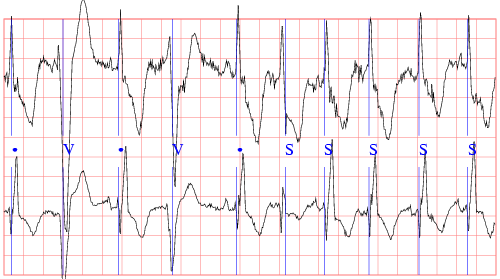

![ECG signal](https://ars.els-cdn.com/content/image/1-s2.0-S0950705120307188-gr1.jpg)

a couple of links:
- [exemplary challenge from Physionet](https://physionet.org/content/challenge-2017/1.0.0/)
- [some recent paper on ECG classification](https://doi.org/10.1016/j.knosys.2020.106589)

## our challenge: classify beats as normal or abnormal (arrhytmia)
- we will utilize signals from **svdb** database, and grab subsequent beats (data preprocessing)
- then construct binary classifier using NN, decision trees, ensemble metchods, and SVM or NaiveBayes

# Dataset preparation
1. Download ecg waves from **svdb** database provided by *PhysioNet*
2. Divide signals into samples, each containing single heartbeat (with window size of 96 points, *sampling ratio* = 128 points/s)
3. Take only samples annotated as 'N' (normal beat), or 'S' and 'V' (arrhythmias)

In [1]:
import os
import numpy as np

# install PhysioNet ecg data package
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['ann-pt-summ',
  'Medical Expert Annotations of Unsupported Facts in Doctor-Written and LLM-Generated Patient Summaries'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid u

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [2]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-48,position+48] window
    beats = np.zeros((len(annotations.sample[5:-5]), time_window*2))
    # note that we remove first and last few beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove first and last few annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...800...file
...processing...801...file
...processing...802...file
...processing...803...file
...processing...804...file
...processing...805...file
...processing...806...file
...processing...807...file
...processing...808...file
...processing...809...file
...processing...810...file
...processing...811...file
...processing...812...file
...processing...820...file
...processing...821...file
...processing...822...file
...processing...823...file
...processing...824...file
...processing...825...file
...processing...826...file
...processing...827...file
...processing...828...file
...processing...829...file
...processing...840...file
...processing...841...file
...processing...842...file
...processing...843...file
...processing...844...file
...processing...845...file
...processing...846...file
...processing...847...file
...processing...848...file
...processing...849...file
...processing...850...file
...processing...851...file
...processing...852...file
...processing...853...file
.

['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N'
 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'S' 'N' 'N' 'N' 'N' 'N']


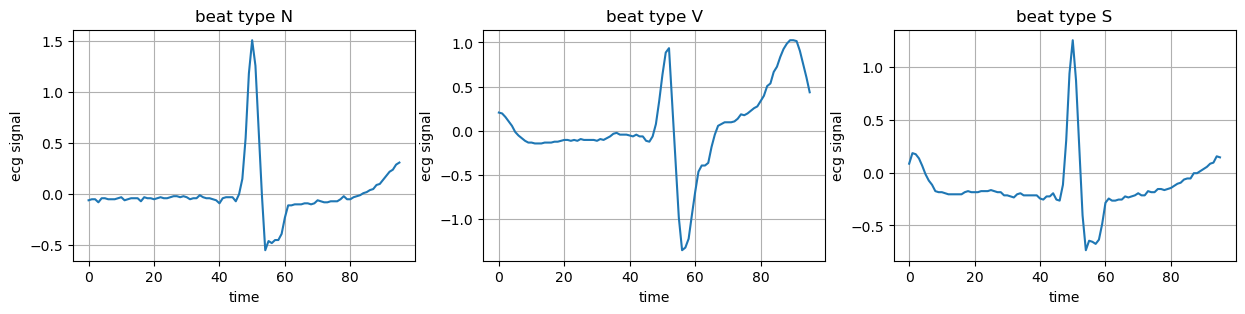

In [3]:
# show example samples
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
print(all_annotations[0:50])
sample_number = [0,549,44]
for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

# Experiments

0. Preliminaries
> - Divide dataset into train/validation/test subset, and normalize each of them.
> - Define classification accuracy metrics (dataset is imbalanced)
>>Confusion matrix
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h |
```
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$

1. Standard classifiers: *naive Bayes* and *SVM*
2. Decision Tree with optimized max_depth
3. Random Forest with vector of features

In [4]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training
# we take only some part of the whole dataset
X, y = all_beats[::10], all_annotations[::10]

# train/validation/test set splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a

12859 2756 2756


In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

svc = SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

svc = SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.8255
Arrhythmia accuracy, Acc_A = 0.3892
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.9463
Arrhythmia accuracy, Acc_A = 0.5538
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.9380
Arrhythmia accuracy, Acc_A = 0.7627
-----------------------------------


Summary of this part:
1. The goal is to maximize both metrics Acc_T and Acc_A at the same time
1. naive Bayes performs rather poorly
> - problem with data imbalace
2. SVM has simillar problem, but after data balacing works quite good

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.8610
Arrhythmia accuracy, Acc_A = 0.7437
-----------------------------------
1 0.0918 0.7188
2 0.1016 0.7955
3 0.8316 0.4006
4 0.8022 0.4602
5 0.8004 0.5142
6 0.8004 0.5938
7 0.8628 0.5852
8 0.7177 0.7443
9 0.8592 0.6591
10 0.8233 0.7188
11 0.8589 0.6960
12 0.8472 0.7188
13 0.8599 0.7188
14 0.8596 0.7301
15 0.8690 0.7301
16 0.8338 0.7358
17 0.8374 0.7528
18 0.8567 0.7472
19 0.8411 0.7500
20 0.8411 0.7358
21 0.8494 0.7472
22 0.8505 0.7415
23 0.8527 0.7415
24 0.8491 0.7301
25 0.8520 0.7358


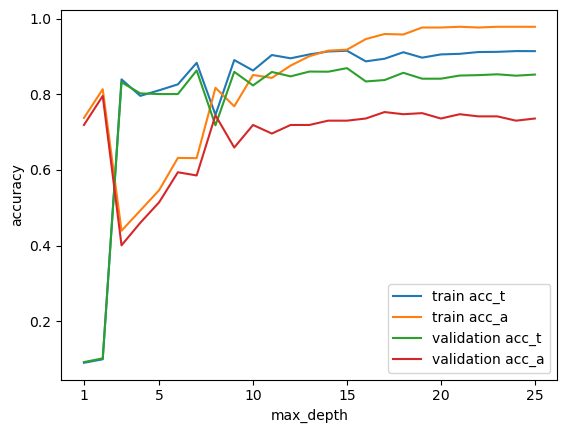

In [6]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy',
                                 class_weight='balanced',
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print('{0:d} {1:.4f} {2:4.4f}'.format(max_depth, acc_t_val, acc_a_val))

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [7]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')

# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=14)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

-----------------------------------
DT: Acc_A maximized
Total accuracy, Acc_T = 0.8407
Arrhythmia accuracy, Acc_A = 0.7215
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized
Total accuracy, Acc_T = 0.8752
Arrhythmia accuracy, Acc_A = 0.6962
-----------------------------------


In [8]:
# feature vector via PCA (dimensionlality reduction) works poorly
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=10)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with PCA')

-----------------------------------
DT with PCA
Total accuracy, Acc_T = 0.8385
Arrhythmia accuracy, Acc_A = 0.7215
-----------------------------------


Summary:
1. Decision Tree works a bit worse (than SVM) and has tendency to overfit. We consider two types of hyperparameters:
> - *max_depth*
> - *min_samples_leaf*
2. Tunning *max_depth* gives Acc_A (*max_depth*=8), or Acc_T & Acc_A (*max_depth*=13) maximum value
3. Simple dimensionality reduction using PCA works rather poorly

In [9]:
import pywt

# extract features using different wavelets and simple differences
def extract_features(input_sample):
    out = np.array([])
# sym8
    cA = pywt.downcoef('a', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cD)
# db6/9
    cA = pywt.downcoef('a', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cD)
    cA = pywt.downcoef('a', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cD)
# dmey
    cA = pywt.downcoef('a', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cD)

# differences
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t+1]-input_sample[t]
    out = np.append(out,differences)
    return out

# collect vector of features for all samples
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data])

X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=15)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy',
                             n_estimators=500,
                             max_depth=10,
                             class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

(12859, 64)
(2756, 64)
-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.8523
Arrhythmia accuracy, Acc_A = 0.6772
-----------------------------------
-----------------------------------
RF with wavelets
Total accuracy, Acc_T = 0.9499
Arrhythmia accuracy, Acc_A = 0.6741
-----------------------------------
-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.9082
Arrhythmia accuracy, Acc_A = 0.4209
-----------------------------------


# Tasks to do
Please choose and complete just **one** of them:
1. Modify classifier to get **accuracy > 0.81** for both Acc_T *and* Acc_A
> - play with classifier hyperparameters
> - add some other features, e.g:
>> - [mean of absolute value (MAV) of signal](https://www.researchgate.net/publication/46147272_Sequential_algorithm_for_life_threatening_cardiac_pathologies_detection_based_on_mean_signal_strength_and_EMD_functions)
>> - some other signal features from [scipy signal](https://docs.scipy.org/doc/scipy/reference/signal.html#peak-finding),
>> - distances between previous and next heartbeats are strong features, see e.g. [here](https://link.springer.com/article/10.1007/s11760-009-0136-1),
>> - it may be also usefull to perform some feature selection, e.g. choose these with variance higher than some assumed threshold (*intuition*: variance measures amount of information in a given feature), or use *model.feature_importances_* attribute (for more see [here](https://scikit-learn.org/stable/modules/feature_selection.html))
> - balance dataset by yourself: equalize the size of each of 3 groups (hint: take the whole dataset)
> - or build your own classifier using [MLP](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#classification)
2. Compare results for Random Forest with AdaBoost classifier
> - try to figure out why the default Ada setup won't work good
> - and fix this problem (hint: resampling)
> - try Ada with different *base_estimators*
> - what will happen if you use too deep decision tree as a base estimator?
3. Add deep-neural classifier (like one in the previous labs) and compare its preformance with today's best classifier
> - at first you should create *torch.utils.data.DataLoader* object, see [here](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)

In [29]:
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

class HeartbeatDataset(Dataset):
    def __init__(self, signals, annotations):
        self.signals = signals
        self.annotations = annotations
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx]
        annotation = self.annotations[idx]
        return signal, annotation
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
import os
import numpy as np
import torch.nn.functional as F

# install PhysioNet ecg data package
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'svdb_dir')
wfdb.dl_database('svdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['ann-pt-summ',
  'Medical Expert Annotations of Unsupported Facts in Doctor-Written and LLM-Generated Patient Summaries'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-dataset-sdoh',
  'Annotation dataset of social determinants of health from MIMIC-III Clinical Care Database'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid u

Generating record list for: 800
Generating record list for: 801
Generating record list for: 802
Generating record list for: 803
Generating record list for: 804
Generating record list for: 805
Generating record list for: 806
Generating record list for: 807
Generating record list for: 808
Generating record list for: 809
Generating record list for: 810
Generating record list for: 811
Generating record list for: 812
Generating record list for: 820
Generating record list for: 821
Generating record list for: 822
Generating record list for: 823
Generating record list for: 824
Generating record list for: 825
Generating record list for: 826
Generating record list for: 827
Generating record list for: 828
Generating record list for: 829
Generating record list for: 840
Generating record list for: 841
Generating record list for: 842
Generating record list for: 843
Generating record list for: 844
Generating record list for: 845
Generating record list for: 846
Generating record list for: 847
Generati

In [31]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-48,position+48] window
    beats = np.zeros((len(annotations.sample[5:-5]), time_window*2))
    # note that we remove first and last few beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove first and last few annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))

...processing...800...file
...processing...801...file
...processing...802...file
...processing...803...file
...processing...804...file
...processing...805...file
...processing...806...file
...processing...807...file
...processing...808...file
...processing...809...file
...processing...810...file
...processing...811...file
...processing...812...file
...processing...820...file
...processing...821...file
...processing...822...file
...processing...823...file
...processing...824...file
...processing...825...file
...processing...826...file
...processing...827...file
...processing...828...file
...processing...829...file
...processing...840...file
...processing...841...file
...processing...842...file
...processing...843...file
...processing...844...file
...processing...845...file
...processing...846...file
...processing...847...file
...processing...848...file
...processing...849...file
...processing...850...file
...processing...851...file
...processing...852...file
...processing...853...file
.

In [32]:
# Define model
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction)
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 30
# logging frequency
model_args['log_interval'] = 100


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(all_beats, all_annotations, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=1)
print(len(y_train), len(y_val), len(y_test))
# Convert data to PyTorch tensors and move to GPU
X_train = torch.Tensor(X_train).to(device)
y_train = torch.LongTensor(np.where(y_train == 'N', 0.0, np.where(y_train == 'V', 1.0, 2.0)).astype(float)).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.LongTensor(np.where(y_test == 'N', 0.0, np.where(y_test == 'V', 1.0, 2.0)).astype(float)).to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.LongTensor(np.where(y_val == 'N', 0.0, np.where(y_val == 'V', 1.0, 2.0)).astype(float)).to(device)

# Create DataLoader
train_dataset = HeartbeatDataset(X_train, y_train)
test_dataset = HeartbeatDataset(X_test, y_test)
val_dataset = HeartbeatDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=model_args['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=model_args['batch_size'], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=model_args['batch_size'], shuffle=False)

128594 27556 27557


In [37]:
y_train[0].type()

'torch.cuda.LongTensor'

In [25]:
class Deep(nn.Module):
    def __init__(self):
        super(Deep, self).__init__()
        self.fc1 = nn.Linear(96, 300)
        self.fc2 = nn.Linear(300, 20)
        self.fc3 = nn.Linear(20, 3)

    def forward(self, x):
        x = x.view(-1, 96)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [39]:
# Initialize model and move to GPU
model = Deep().to(device)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
class_weights = torch.tensor([1.0, 1.0, 1.0]).to(device) # Poids plus élevés pour les classes 1 et 2
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        print(output[0].type())
        print(target[0].type())
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total_2 = 0
    correct_1_2 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred = pred.squeeze()
            # Réinitialisation des variables
            total_2 += ((target == 1) | (target == 2)).sum().item()
            correct_1_2 += ((target == 1) & (target == pred)).sum().item() + ((target == 2) & (target == pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_1_2 = 100. * correct_1_2 / total_2
    
    print('\nTest set: \nAverage loss: {:.4f}, \nAccuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    print('Accuracy for classes 1 and 2: {}/{} ({:.2f}%)\n'.format(
        correct_1_2, total_2, accuracy_1_2))

for epoch in range(1, model_args['epochs'] + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)

test(model, val_loader)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 1 [0/128594 (0%)]	Loss: 1.207666
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cud

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 1 [25600/128594 (20%)]	Loss: 0.323666
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torc

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda


Test set: 
Average loss: 0.0017, 
Accuracy: 25777/27557 (93.54%)
Accuracy for classes 1 and 2: 1571/3230 (48.64%)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 2 [0/128594 (0%)]	Loss: 0.213501
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 3 [38400/128594 (30%)]	Loss: 0.172204
torc

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 3 [64000/128594 (50%)]	Loss: 0.185435
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torc

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda


Test set: 
Average loss: 0.0011, 
Accuracy: 26385/27557 (95.75%)
Accuracy for classes 1 and 2: 2340/3230 (72.45%)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 4 [0/128594 (0%)]	Loss: 0.107840
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda


Test set: 
Average loss: 0.0010, 
Accuracy: 26427/27557 (95.90%)
Accuracy for classes 1 and 2: 2286/3230 (70.77%)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 5 [0/128594 (0%)]	Loss: 0.213505
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 6 [12800/128594 (10%)]	Loss: 0.125454
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torc

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 7 [102400/128594 (80%)]	Loss: 0.160318
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 7 [128000/128594 (100%)]	Loss: 0.054786
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
to

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 8 [115200/128594 (90%)]	Loss: 0.141376
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 9 [102400/128594 (80%)]	Loss: 0.074137
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 9 [128000/128594 (100%)]	Loss: 0.111576
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor

Test set: 
Average loss: 0.0008, 
Accuracy: 26605/27557 (96.55%)
Accuracy for classes 1 and

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 10 [25600/128594 (20%)]	Loss: 0.097798
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 11 [25600/128594 (20%)]	Loss: 0.074726
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 13 [102400/128594 (80%)]	Loss: 0.123634
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
to

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 13 [128000/128594 (100%)]	Loss: 0.121223
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor

Test set: 
Average loss: 0.0008, 
Accuracy: 26679/27557 (96.81%)
Accuracy for classes 1 and 2: 2698/3230 (83.53%)

torch.cuda.FloatTens

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 14 [128000/128594 (100%)]	Loss: 0.074059
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor

Test set: 
Average loss: 0.0009, 
Accuracy: 26663/27557 (96.76%)
Accuracy for classes 1 and 2: 2727/3230 (84.43%)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 15 [0/128594 (0%)]	Loss: 0.104001
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTe

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda


Test set: 
Average loss: 0.0008, 
Accuracy: 26703/27557 (96.90%)
Accuracy for classes 1 and 2: 2541/3230 (78.67%)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 16 [0/128594 (0%)]	Loss: 0.150435
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torc

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 17 [12800/128594 (10%)]	Loss: 0.101268
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 18 [115200/128594 (90%)]	Loss: 0.068267
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
to

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda


Test set: 
Average loss: 0.0007, 
Accuracy: 26742/27557 (97.04%)
Accuracy for classes 1 and 2: 2643/3230 (81.83%)

torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 20 [0/128594 (0%)]	Loss: 0.161224
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torc

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 20 [89600/128594 (70%)]	Loss: 0.035651
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 20 [115200/128594 (90%)]	Loss: 0.069687
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
to

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 21 [12800/128594 (10%)]	Loss: 0.064351
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
Train Epoch: 21 [76800/128594 (60%)]	Loss: 0.074554
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
tor

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda.FloatTensor
torch.cuda.LongTensor
torch.cuda

KeyboardInterrupt: 

In [27]:
# Initialize model and move to GPU
model = Deep().to(device)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
class_weights = torch.tensor([1.0, 50.0, 50.0]).to(device) # Poids plus élevés pour les classes 1 et 2
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total_2 = 0
    correct_1_2 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred = pred.squeeze()
            # Réinitialisation des variables
            total_2 += ((target == 1) | (target == 2)).sum().item()
            correct_1_2 += ((target == 1) & (target == pred)).sum().item() + ((target == 2) & (target == pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_1_2 = 100. * correct_1_2 / total_2
    
    print('\nTest set: \nAverage loss: {:.4f}, \nAccuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    print('Accuracy for classes 1 and 2: {}/{} ({:.2f}%)\n'.format(
        correct_1_2, total_2, accuracy_1_2))

for epoch in range(1, model_args['epochs'] + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)

test(model, val_loader)

Train Epoch: 1 [0/128594 (0%)]	Loss: 1.143463
Train Epoch: 1 [12800/128594 (10%)]	Loss: 0.695298
Train Epoch: 1 [25600/128594 (20%)]	Loss: 0.651670
Train Epoch: 1 [38400/128594 (30%)]	Loss: 0.466826
Train Epoch: 1 [51200/128594 (40%)]	Loss: 0.405987
Train Epoch: 1 [64000/128594 (50%)]	Loss: 0.588485
Train Epoch: 1 [76800/128594 (60%)]	Loss: 0.353464
Train Epoch: 1 [89600/128594 (70%)]	Loss: 0.347541
Train Epoch: 1 [102400/128594 (80%)]	Loss: 0.328916
Train Epoch: 1 [115200/128594 (90%)]	Loss: 0.857022
Train Epoch: 1 [128000/128594 (100%)]	Loss: 0.624489

Test set: 
Average loss: 0.0031, 
Accuracy: 11522/27557 (41.81%)
Accuracy for classes 1 and 2: 2967/3230 (91.86%)

Train Epoch: 2 [0/128594 (0%)]	Loss: 0.273746
Train Epoch: 2 [12800/128594 (10%)]	Loss: 0.375190
Train Epoch: 2 [25600/128594 (20%)]	Loss: 0.432963
Train Epoch: 2 [38400/128594 (30%)]	Loss: 0.564909
Train Epoch: 2 [51200/128594 (40%)]	Loss: 0.214217
Train Epoch: 2 [64000/128594 (50%)]	Loss: 0.352912
Train Epoch: 2 [76800/1

Train Epoch: 13 [25600/128594 (20%)]	Loss: 0.302630
Train Epoch: 13 [38400/128594 (30%)]	Loss: 0.128524
Train Epoch: 13 [51200/128594 (40%)]	Loss: 0.312127
Train Epoch: 13 [64000/128594 (50%)]	Loss: 0.199929
Train Epoch: 13 [76800/128594 (60%)]	Loss: 0.194587
Train Epoch: 13 [89600/128594 (70%)]	Loss: 0.131283
Train Epoch: 13 [102400/128594 (80%)]	Loss: 0.181838
Train Epoch: 13 [115200/128594 (90%)]	Loss: 0.196132
Train Epoch: 13 [128000/128594 (100%)]	Loss: 0.106817

Test set: 
Average loss: 0.0017, 
Accuracy: 23039/27557 (83.60%)
Accuracy for classes 1 and 2: 3034/3230 (93.93%)

Train Epoch: 14 [0/128594 (0%)]	Loss: 0.219396
Train Epoch: 14 [12800/128594 (10%)]	Loss: 0.112738
Train Epoch: 14 [25600/128594 (20%)]	Loss: 0.160356
Train Epoch: 14 [38400/128594 (30%)]	Loss: 0.397490
Train Epoch: 14 [51200/128594 (40%)]	Loss: 0.086691
Train Epoch: 14 [64000/128594 (50%)]	Loss: 0.209969
Train Epoch: 14 [76800/128594 (60%)]	Loss: 0.214453
Train Epoch: 14 [89600/128594 (70%)]	Loss: 0.231841
T

Train Epoch: 25 [25600/128594 (20%)]	Loss: 0.057943
Train Epoch: 25 [38400/128594 (30%)]	Loss: 0.227130
Train Epoch: 25 [51200/128594 (40%)]	Loss: 0.178308
Train Epoch: 25 [64000/128594 (50%)]	Loss: 0.100500
Train Epoch: 25 [76800/128594 (60%)]	Loss: 0.112780
Train Epoch: 25 [89600/128594 (70%)]	Loss: 0.055744
Train Epoch: 25 [102400/128594 (80%)]	Loss: 0.253424
Train Epoch: 25 [115200/128594 (90%)]	Loss: 0.133064
Train Epoch: 25 [128000/128594 (100%)]	Loss: 0.082950

Test set: 
Average loss: 0.0016, 
Accuracy: 23836/27557 (86.50%)
Accuracy for classes 1 and 2: 3039/3230 (94.09%)

Train Epoch: 26 [0/128594 (0%)]	Loss: 0.117427
Train Epoch: 26 [12800/128594 (10%)]	Loss: 0.076655
Train Epoch: 26 [25600/128594 (20%)]	Loss: 0.501070
Train Epoch: 26 [38400/128594 (30%)]	Loss: 0.101254
Train Epoch: 26 [51200/128594 (40%)]	Loss: 0.193111
Train Epoch: 26 [64000/128594 (50%)]	Loss: 0.085848
Train Epoch: 26 [76800/128594 (60%)]	Loss: 0.283012
Train Epoch: 26 [89600/128594 (70%)]	Loss: 0.213219
T

In [28]:
# Initialize model and move to GPU
model = Deep().to(device)

# Define optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
class_weights = torch.tensor([1.0, 10.0, 10.0]).to(device) # Poids plus élevés pour les classes 1 et 2
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training function
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total_2 = 0
    correct_1_2 = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred = pred.squeeze()
            # Réinitialisation des variables
            total_2 += ((target == 1) | (target == 2)).sum().item()
            correct_1_2 += ((target == 1) & (target == pred)).sum().item() + ((target == 2) & (target == pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_1_2 = 100. * correct_1_2 / total_2
    
    print('\nTest set: \nAverage loss: {:.4f}, \nAccuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    print('Accuracy for classes 1 and 2: {}/{} ({:.2f}%)\n'.format(
        correct_1_2, total_2, accuracy_1_2))

for epoch in range(1, model_args['epochs'] + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)

test(model, val_loader)

Train Epoch: 1 [0/128594 (0%)]	Loss: 1.154461
Train Epoch: 1 [12800/128594 (10%)]	Loss: 0.808485
Train Epoch: 1 [25600/128594 (20%)]	Loss: 0.622021
Train Epoch: 1 [38400/128594 (30%)]	Loss: 0.620726
Train Epoch: 1 [51200/128594 (40%)]	Loss: 0.489411
Train Epoch: 1 [64000/128594 (50%)]	Loss: 0.682873
Train Epoch: 1 [76800/128594 (60%)]	Loss: 0.416595
Train Epoch: 1 [89600/128594 (70%)]	Loss: 0.302972
Train Epoch: 1 [102400/128594 (80%)]	Loss: 0.411338
Train Epoch: 1 [115200/128594 (90%)]	Loss: 0.465089
Train Epoch: 1 [128000/128594 (100%)]	Loss: 0.327985

Test set: 
Average loss: 0.0030, 
Accuracy: 25166/27557 (91.32%)
Accuracy for classes 1 and 2: 2652/3230 (82.11%)

Train Epoch: 2 [0/128594 (0%)]	Loss: 0.299441
Train Epoch: 2 [12800/128594 (10%)]	Loss: 0.383826
Train Epoch: 2 [25600/128594 (20%)]	Loss: 0.452993
Train Epoch: 2 [38400/128594 (30%)]	Loss: 0.565667
Train Epoch: 2 [51200/128594 (40%)]	Loss: 0.566310
Train Epoch: 2 [64000/128594 (50%)]	Loss: 0.582154
Train Epoch: 2 [76800/1

Train Epoch: 13 [25600/128594 (20%)]	Loss: 0.171087
Train Epoch: 13 [38400/128594 (30%)]	Loss: 0.171609
Train Epoch: 13 [51200/128594 (40%)]	Loss: 0.123720
Train Epoch: 13 [64000/128594 (50%)]	Loss: 0.211052
Train Epoch: 13 [76800/128594 (60%)]	Loss: 0.316380
Train Epoch: 13 [89600/128594 (70%)]	Loss: 0.109593
Train Epoch: 13 [102400/128594 (80%)]	Loss: 0.372030
Train Epoch: 13 [115200/128594 (90%)]	Loss: 0.121266
Train Epoch: 13 [128000/128594 (100%)]	Loss: 0.379259

Test set: 
Average loss: 0.0020, 
Accuracy: 25494/27557 (92.51%)
Accuracy for classes 1 and 2: 2878/3230 (89.10%)

Train Epoch: 14 [0/128594 (0%)]	Loss: 0.286359
Train Epoch: 14 [12800/128594 (10%)]	Loss: 0.255994
Train Epoch: 14 [25600/128594 (20%)]	Loss: 0.133493
Train Epoch: 14 [38400/128594 (30%)]	Loss: 0.290360
Train Epoch: 14 [51200/128594 (40%)]	Loss: 0.659422
Train Epoch: 14 [64000/128594 (50%)]	Loss: 0.208764
Train Epoch: 14 [76800/128594 (60%)]	Loss: 0.202549
Train Epoch: 14 [89600/128594 (70%)]	Loss: 0.265055
T

Train Epoch: 25 [25600/128594 (20%)]	Loss: 0.089952
Train Epoch: 25 [38400/128594 (30%)]	Loss: 0.121752
Train Epoch: 25 [51200/128594 (40%)]	Loss: 0.206259
Train Epoch: 25 [64000/128594 (50%)]	Loss: 0.172234
Train Epoch: 25 [76800/128594 (60%)]	Loss: 0.098162
Train Epoch: 25 [89600/128594 (70%)]	Loss: 0.061796
Train Epoch: 25 [102400/128594 (80%)]	Loss: 0.384515
Train Epoch: 25 [115200/128594 (90%)]	Loss: 0.136206
Train Epoch: 25 [128000/128594 (100%)]	Loss: 0.068136

Test set: 
Average loss: 0.0017, 
Accuracy: 25647/27557 (93.07%)
Accuracy for classes 1 and 2: 2998/3230 (92.82%)

Train Epoch: 26 [0/128594 (0%)]	Loss: 0.138161
Train Epoch: 26 [12800/128594 (10%)]	Loss: 0.295813
Train Epoch: 26 [25600/128594 (20%)]	Loss: 0.153033
Train Epoch: 26 [38400/128594 (30%)]	Loss: 0.178271
Train Epoch: 26 [51200/128594 (40%)]	Loss: 0.076196
Train Epoch: 26 [64000/128594 (50%)]	Loss: 0.144315
Train Epoch: 26 [76800/128594 (60%)]	Loss: 0.091146
Train Epoch: 26 [89600/128594 (70%)]	Loss: 0.175079
T